# Identificación y eliminación de observaciones

Voy a armar un modelo OLS con variables que no tienen ningún sentido, sólo las uso como ejemplo. La finalidad es que sepan cómo identificar aquellas observaciones con residuos (a.k.a. errores) que escapan a la normalidad. 

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor #para calcular el VIF
import statsmodels.api as sm #para modelos
import scipy.stats as stats #para calcular los residuos estandarizados
from scipy.stats import pearsonr #para calcular correlaciones
from sklearn.metrics import mean_squared_error #para calcular el MSE
import matplotlib.pyplot as plt #para gráficos
from string import ascii_letters #para gráficos
import seaborn as sns #para gráficos

In [2]:
bdd=pd.read_csv('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/clases/habitaclia4043.csv')

In [3]:
len(bdd)

4043

Selecciono variables.

In [4]:
variables = [
    "Ln_total_pr",
    "ascensor",
    "interac_planta",
    "superficie_terraza_m2",
    "Inverse_Age",
    "CT_renta_alta_CPA",
    "Estado_contemporaneidad_calidad",
    "superficie",
    "dum_acces_viappal",
]

Elimino NAs.

In [5]:
df=bdd[variables]
df=df.dropna()
len(df)

3853

In [6]:
X=df.drop(columns=["Ln_total_pr"])
y=df["Ln_total_pr"]

In [7]:
# Agregar una constante (Beta) a la matriz X para el término de intercepción del modelo
X = sm.add_constant(X)

# Crear el modelo de regresión lineal
ols = sm.OLS(y, X) 

# Ajustar el modelo a los datos
results = ols.fit()

# Imprimir el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Ln_total_pr   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2550.
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        13:46:11   Log-Likelihood:                 125.48
No. Observations:                3853   AIC:                            -235.0
Df Residuals:                    3845   BIC:                            -184.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ascensor  

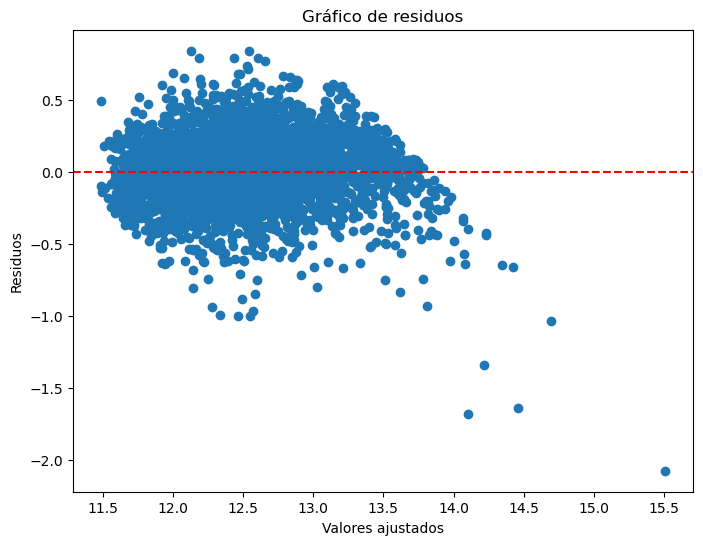

In [8]:
# Calcular los residuos del modelo
residuos = results.resid # 'results' es como llamé al objeto que contiene los resultados de mi modelo 
                         # en la celda 26
# Graficar los residuos
plt.figure(figsize=(8, 6))
plt.scatter(results.fittedvalues, residuos) # le indico que trabaje sobre 'results'
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de residuos')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

Noten en los gráficos que vienen a continuación que aquellos residuos que escapan a la normalidad están hacia la izquierda de la campana.

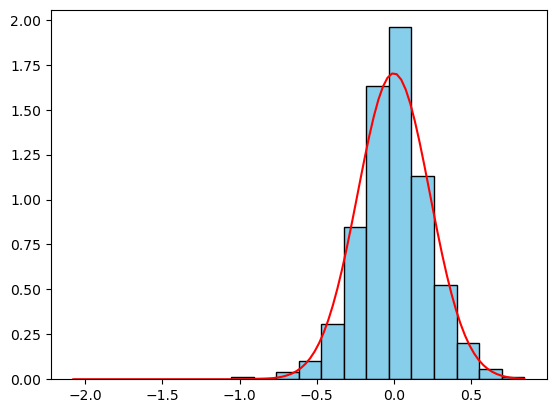

In [9]:
# Datos
data = residuos

# Crear histograma
plt.hist(data, bins=20, color='skyblue', edgecolor='black', density=True)

# Calcular la media y la desviación estándar para la campana de Gauss
mu = np.mean(data)
sigma = np.std(data)

# Definir el rango de valores para la campana de Gauss
x = np.linspace(min(data), max(data), 100)

# Calcular la función de densidad de probabilidad para la campana de Gauss
pdf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Graficar la campana de Gauss
plt.plot(x, pdf, color='red')

# Mostrar el gráfico
plt.show()

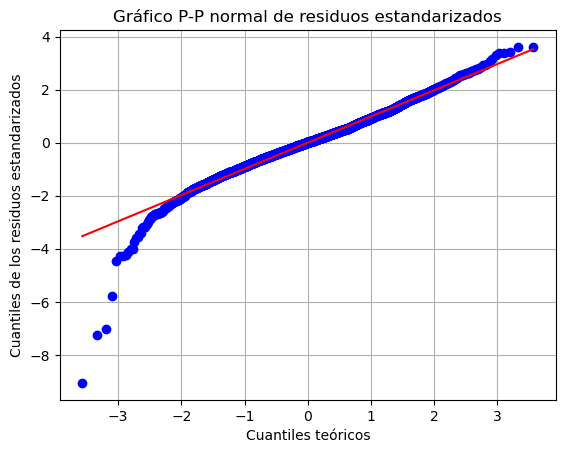

In [10]:
# Calcular los residuos estandarizados
residuos_estandarizados = results.get_influence().resid_studentized_internal ## 'results' es como yo llamé al objeto que contiene los resultados de mi modelo en la celda 26 ##

# Calcular la distribución acumulativa de los residuos estandarizados
distribucion_acumulativa = stats.probplot(residuos_estandarizados, dist="norm", plot=plt)

# Personalizar el gráfico
plt.title('Gráfico P-P normal de residuos estandarizados')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los residuos estandarizados')
plt.grid(True)
plt.show()

Como el problema es hacia la izquierda de la campana (residuos con valores más bajos), voy a identificar el valor que está más hacia la derecha para hacer un *espejo*. Es decir, si el valor más hacia la derecha (el más alto) fuera 0.75, voy a buscar que hacia la izquierda el corte se haga en **- 0.75**.

Como había guardado mis residuos en un objeto llamado `residuos`, voy a trabajar sobre él para ver el valor más alto.

In [13]:
residuos.max()

0.8453629639805254

Ya vemos que es 0.84; por tanto, mi valor de corte será el mismo pero en negativo. Ahora, lo importante: **¿Cómo sé qué observaciones tienen un residuo por debajo de -0.84?**

Una vez más, voy a hacer uso del objeto `residuos`: lo voy a exportar a Excel, ordenaré los datos de menor a mayor, y como tenemos el índice (la columna de la izquierda marcada en negrita, que es como el ID de cada observación) lo usaremos para saber qué observaciones del dataframe que usamos en el modelo (`df`) debemos quitar.

In [15]:
residuos.to_excel('residuos-prueba.xlsx')

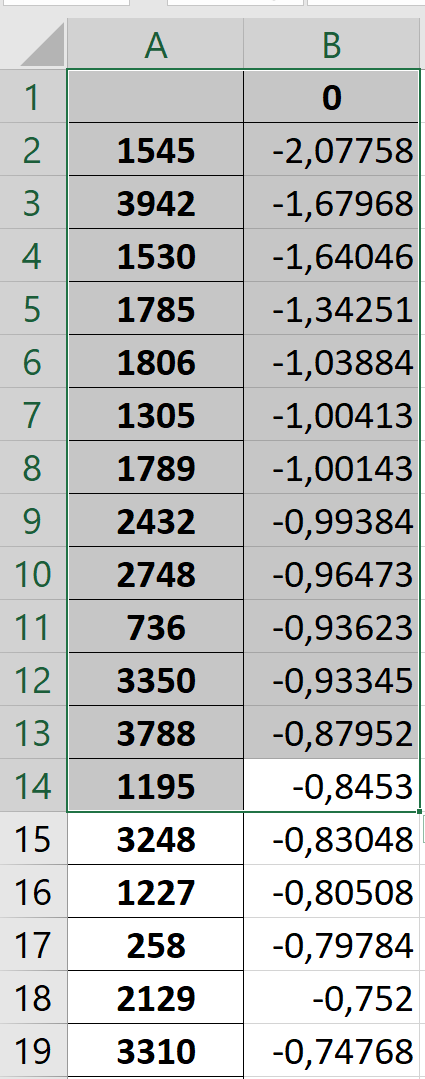

Creo una lista que tenga los índices de esos outliers residuales.

In [16]:
indices_outliers = [1545, 3942, 1530, 1785, 1806, 1305, 1789, 2432, 2748, 736, 3350, 3788, 1195]

Y ahora creo un nueva base de datos, `df_nuevo`, sobre la cual hago un dropeo de esos índices.

In [17]:
df_nuevo = df.drop(indices_outliers)
len(df_nuevo)

3840

Ahora vuelvo a correr un modelo pero con `df_nuevo` y veo los gráficos para evaluar los supuestos. (Noten que la única diferencia con el código anterior es que ya no corro `print(results.summary())`, por eso me aparecen directamente los gráficos.)

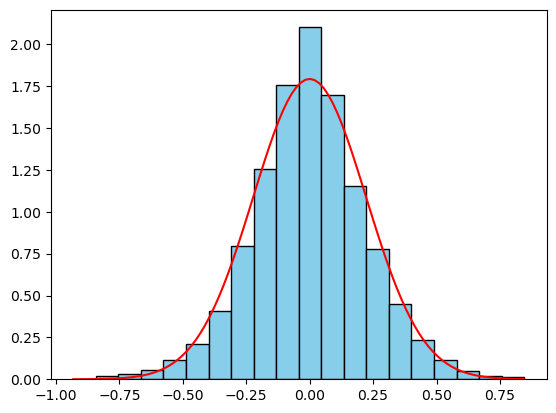

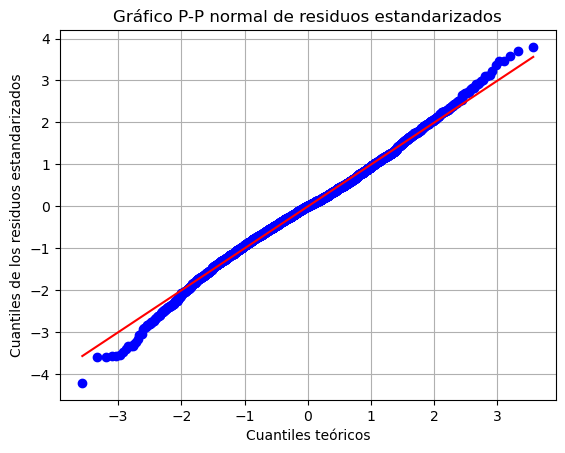

In [18]:
X2=df_nuevo.drop(columns=["Ln_total_pr"])
y2=df_nuevo["Ln_total_pr"]

# Agregar una constante (Beta) a la matriz X para el término de intercepción del modelo
X2 = sm.add_constant(X2)

# Crear el modelo de regresión lineal
ols2 = sm.OLS(y2, X2) 

# Ajustar el modelo a los datos
results2 = ols2.fit()

residuos2 = results2.resid

# Datos
data = residuos2

# Crear histograma
plt.hist(data, bins=20, color='skyblue', edgecolor='black', density=True)

# Calcular la media y la desviación estándar para la campana de Gauss
mu = np.mean(data)
sigma = np.std(data)

# Definir el rango de valores para la campana de Gauss
x = np.linspace(min(data), max(data), 100)

# Calcular la función de densidad de probabilidad para la campana de Gauss
pdf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Graficar la campana de Gauss
plt.plot(x, pdf, color='red')

# Mostrar el gráfico
plt.show()

# Calcular los residuos estandarizados
residuos_estandarizados2 = results2.get_influence().resid_studentized_internal ## 'results' es como yo llamé al objeto que contiene los resultados de mi modelo en la celda 26 ##

# Calcular la distribución acumulativa de los residuos estandarizados
distribucion_acumulativa= stats.probplot(residuos_estandarizados2, dist="norm", plot=plt)

# Personalizar el gráfico
plt.title('Gráfico P-P normal de residuos estandarizados')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los residuos estandarizados')
plt.grid(True)
plt.show()

¡Y ahora el gráfico mejoró! ¿Puede mejorar más? Sí, principalmente porque introduje variables que no tienen mucho sentido, sólo a manera de ejemplo. Además, si se dan cuenta, en el nuevo gráfico de campana esta sigue sin ser perfecta: ahora podríamos hacer un corte a la altura de 0.75 y -0.75 para mejorarla y en consecuencia también mejorar el gráfico de los cuantiles teóricos (el último).

¿Por qué si ya quitamos los outliers residuales **del primero modelo**, el segundo aún muestra imperfecciones? Porque ahora trabaja con otros datos. Por tanto, sus estimaciones y residuos no tienen por qué ser idénticos al que teníamos inicialmente.